In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

In [32]:
# Load your dataset
data = pd.read_csv('merged_file.csv')

In [33]:
# Set the date column as the index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

In [34]:
# Fill NaN values with forward fill
data.fillna(method='bfill', inplace=True)

In [35]:
# Check for NaN values
print("Number of NaN values:", data.isnull().sum().sum())

Number of NaN values: 0


In [36]:
# Split the data into features (X) and target (y)
X = data.drop(['Miscellaneous electric load for the South Wing', 'Miscellaneous electric load for the North Wing',
               'Lighting load for the South Wing', 'Heating Ventilation and Air Conditioning load for the South Wing',
               'Heating Ventilation and Air Conditioning load for the North Wing'], axis=1)


In [37]:
# Define a list of target variables
target_columns = ['Miscellaneous electric load for the South Wing', 'Miscellaneous electric load for the North Wing',
                   'Lighting load for the South Wing', 'Heating Ventilation and Air Conditioning load for the South Wing',
                   'Heating Ventilation and Air Conditioning load for the North Wing']


In [38]:
# Use a fixed split technique (e.g., train on the first 80% of the data, test on the remaining 20%)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]

In [39]:
# Initialize an empty dictionary to store GRU models
gru_models = {}

In [10]:
# Train a GRU model for each target variable
for target_column in target_columns:
    y_train = data[target_column][:train_size]
    y_test = data[target_column][train_size:]

    # Reshape the data for GRU input (3D tensor with shape: [samples, time steps, features])
    X_train_reshaped = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_reshaped = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

    # Build the GRU model
    model = Sequential()
    model.add(GRU(50, activation='relu', input_shape=(1, X_train.shape[1])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model with early stopping
    es = EarlyStopping(monitor='val_loss', patience=10)
    model.fit(X_train_reshaped, y_train, epochs=100, validation_split=0.2, callbacks=[es],batch_size=32)

    # Make predictions
    gru_predictions = model.predict(X_test_reshaped)

    # Calculate RMSE for each model
    gru_rmse = np.sqrt(mean_squared_error(y_test, gru_predictions))
    print(f"GRU RMSE for {target_column}: {gru_rmse}")

    # Store the trained model
    gru_models[target_column] = model

Epoch 1/100
1294/1294 [==============================] - 7s 4ms/step - loss: 13562.4824 - val_loss: 374.4373
Epoch 2/100
1294/1294 [==============================] - 5s 4ms/step - loss: 101.3145 - val_loss: 282.9949
Epoch 3/100
1294/1294 [==============================] - 5s 4ms/step - loss: 151.6025 - val_loss: 181.1479
Epoch 4/100
1294/1294 [==============================] - 4s 3ms/step - loss: 37.7207 - val_loss: 171.3436
Epoch 5/100
1294/1294 [==============================] - 4s 3ms/step - loss: 25.2692 - val_loss: 146.2126
Epoch 6/100
1294/1294 [==============================] - 4s 3ms/step - loss: 32.4125 - val_loss: 143.4823
Epoch 7/100
1294/1294 [==============================] - 4s 3ms/step - loss: 36.7786 - val_loss: 328.9314
Epoch 8/100
1294/1294 [==============================] - 4s 3ms/step - loss: 34.3875 - val_loss: 133.9824
Epoch 9/100
1294/1294 [==============================] - 5s 4ms/step - loss: 28.0733 - val_loss: 145.1536
Epoch 10/100
1294/1294 [=================

In [40]:
# Define a function to create the GRU model
def create_gru_model(activation='relu', units=50, optimizer='adam'):
    model = Sequential()
    model.add(GRU(units, activation=activation, input_shape=(1, X_train.shape[1])))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [29]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasRegressor


ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

In [41]:
# Create a KerasRegressor wrapper for GridSearchCV
gru_regressor = KerasRegressor(build_fn=create_gru_model, verbose=0)


NameError: name 'KerasRegressor' is not defined

In [ ]:
# Define hyperparameter grid for grid search
param_grid = {
    'activation': ['relu', 'tanh'],
    'units': [50, 100],
    'optimizer': ['adam', 'rmsprop']
}


In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # You can remove this if data is already scaled
    ('gru', gru_regressor)
])

In [ ]:
# Perform grid search for hyperparameter optimization
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_result = grid.fit(X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1]), data['Miscellaneous electric load for the South Wing'][:train_size])


In [ ]:
# Get the best model
best_model = grid_result.best_estimator_

# Train the best model on the entire training set
best_model.named_steps['gru'].fit(X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1]), data['Miscellaneous electric load for the South Wing'][:train_size], epochs=100, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=10)], batch_size=32)

# Make predictions
gru_predictions = best_model.named_steps['gru'].predict(X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1]))


In [ ]:
# Calculate RMSE for the best model
gru_rmse = np.sqrt(mean_squared_error(data['Miscellaneous electric load for the South Wing'][train_size:], gru_predictions))
print(f"GRU RMSE for Miscellaneous electric load for the South Wing: {gru_rmse}")


In [ ]:
# Store the best model
gru_models['Miscellaneous electric load for the South Wing'] = best_model.named_steps['gru']


In [ ]:
# Visualize results for the best model
plt.figure(figsize=(12, 6))
plt.title('GRU Predictions for Miscellaneous electric load for the South Wing')
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, gru_predictions, label='Predicted')
plt.legend()
plt.show()

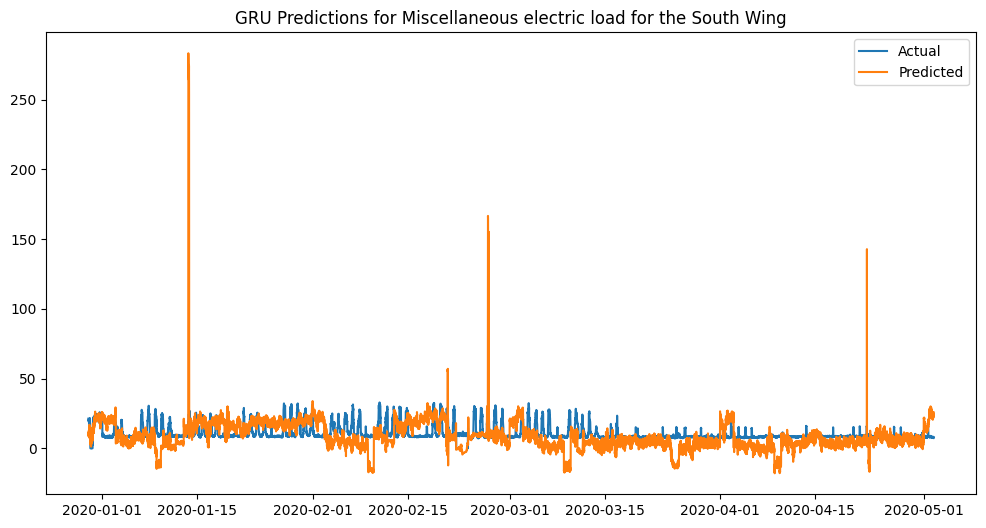

In [11]:
# Visualize results for one of the models
plt.figure(figsize=(12, 6))
plt.title('GRU Predictions for Miscellaneous electric load for the South Wing')
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, gru_predictions, label='Predicted')
plt.legend()
plt.show()